In [6]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import sys
from iminuit import Minuit
from matplotlib.colors import ListedColormap
from tqdm import tqdm
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.inspection import permutation_importance

# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
# 6.2sec

In [7]:
sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH, simpson38
from ExternalFunctions import nice_string_output, add_text_to_ax 

In [8]:
COLOUR = ['#1E90FF', # 0 # Dodgerblue
          '#FFBF00', # 1 # Amber
          '#FF6347', # 2 # Tomato
          '#00A86B', # 3 # Jade
          '#8A2BE2', # 4 # Blueviolet
          '#FF6FFF', # 5 # Ultra Pink
          '#00CCFF', # 6 # Vivid Sky Blue
          '#00ff40', # 7 # Erin
          '#FF004F', # 8 # Folly
          '#0063A6', # 9 # Lapis Lazuli
        ]
def setMplParam(classNum):
    # Define effective colors, line styles, and markers based on the class number
   
    LINE = ['-', '-.', '--', '-.', ':','--','-.','-', ':', '--']
    MARKER = ['.','*', '^', 's', '.', 'p', 'o', 's', '.', 'd']
    COLOUR_EFF = COLOUR[:classNum]
    LINE_EFF = LINE[:classNum]
    MARKER_EFF = MARKER[:classNum]

    # Set the color cycle for lines including color, line style, and marker
    plt.rcParams['axes.prop_cycle'] = (plt.cycler(color=COLOUR_EFF) +
                                       plt.cycler(linestyle=LINE_EFF)+
                                       plt.cycler(marker=MARKER_EFF))

    # Set default line and marker sizes
    plt.rcParams['lines.markersize'] = 3  # Example size
    plt.rcParams['lines.linewidth'] = 2   # Example width for lines

    # Set label and title sizes
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['axes.titlesize'] = 20

    # Set tick properties
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['ytick.labelsize'] = 20

    # Set legend font size
    plt.rcParams['legend.fontsize'] = 12

    # Enable and configure grid
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.8
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.linewidth'] = 1

    # Set axes line width
    plt.rcParams['axes.linewidth'] = 2

    # Set tick sizes and widths
    plt.rcParams['xtick.major.size'] = 7
    plt.rcParams['xtick.major.width'] = 3
    plt.rcParams['xtick.minor.size'] = 2
    plt.rcParams['xtick.minor.width'] = 2

    plt.rcParams['ytick.major.size'] = 7
    plt.rcParams['ytick.major.width'] = 3
    plt.rcParams['ytick.minor.size'] = 2
    plt.rcParams['ytick.minor.width'] = 2

setMplParam(10)


In [9]:
def readTraining():
    path = ''
    fileName = 'earning_potential_train_test.txt'
    data = pd.read_csv(path + fileName)
    data['earning'] = data['earning'].apply(lambda x: x.strip() == '>50K')
    data.columns = ['age', 'education', 'gender', 'hpw', 'isHigh50']
    return data
data_training = readTraining()
data_training.head()
print(data_training.shape)

(4500, 5)


In [10]:
def readReal():
    path = ''
    fileName = 'earning_potential_real.txt'
    data = pd.read_csv(path + fileName)
    data = data.drop('ID', axis=1)
    data.columns = ['age', 'education', 'gender', 'hpw']
    return data
data_real = readReal()
print(data_real.head())
print(data_real.shape)

   age  education  gender  hpw
0   40          9       1   40
1   28         13       1   48
2   49         10       1   30
3   32          9       0   40
4   33          9       0   40
(3612, 4)


In [11]:
def writeDFtoTxt(data, fileName):
    path = ''
    data.to_csv(path+fileName, sep=' ', index=False, header=False)

In [12]:
def dichotomise(data):
    low = data[data['isHigh50'] == False]
    high = data[data['isHigh50'] == True]
    print('Low:', low.shape)
    print('High:', high.shape)
    return low, high
low, high = dichotomise(data_training)

Low: (3409, 5)
High: (1091, 5)


In [13]:
def getHistoParamWithBinWidth(data, binwidth, isDensity = False):
    start_bin = np.floor(data.min()) - 0.5 * binwidth
    end_bin = np.ceil(data.max()) + 0.5 * binwidth
    bins = np.arange(start_bin, end_bin + binwidth, binwidth)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    counts, x_edges = np.histogram(data, bins=bins, density=isDensity)
    x_centres = x_edges[:-1] + binwidth/2
    return bins, counts, bin_centers, x_centres

In [14]:
def getHistoParam(data, isDensity = False):
    Nbins = int(np.sqrt(data.shape[0]/2))
    counts, x_edges = np.histogram(data, bins=Nbins, density=isDensity)
    binwidth = x_edges[1] - x_edges[0]
    x_centres = x_edges[:-1] + binwidth/2
    return Nbins, binwidth, counts, x_centres

Low: (3409, 5)
High: (1091, 5)


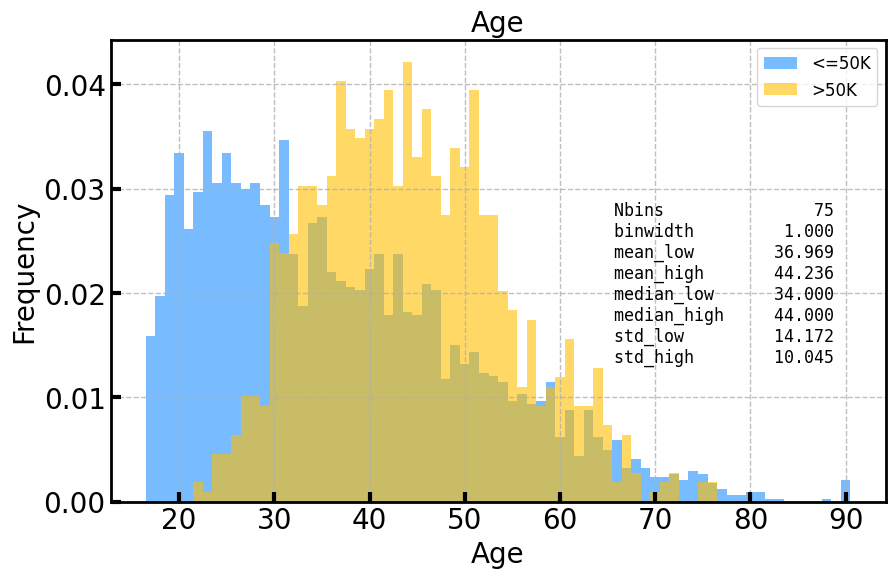

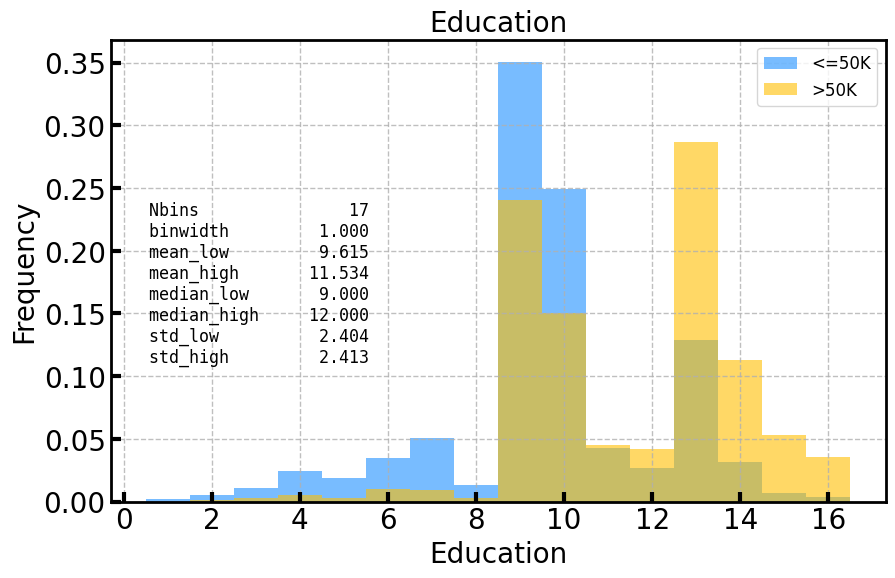

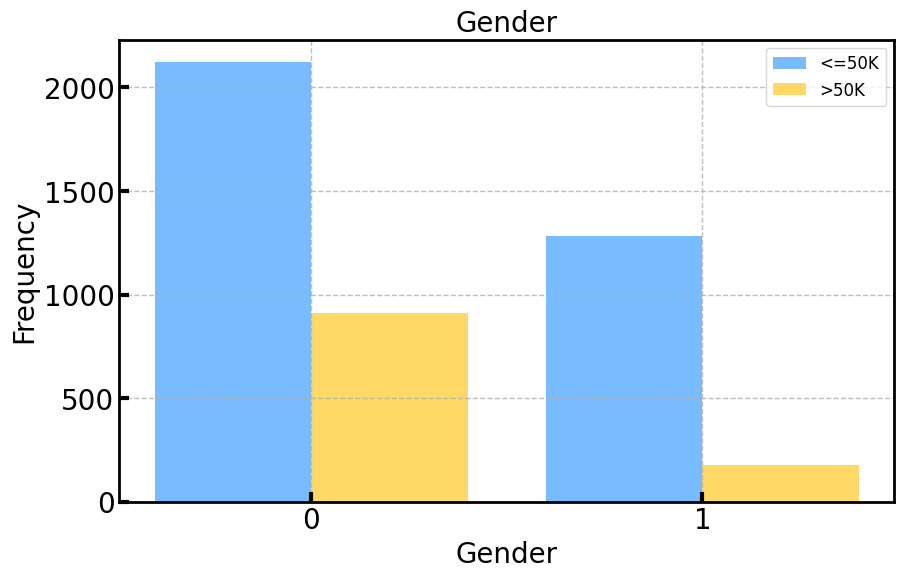

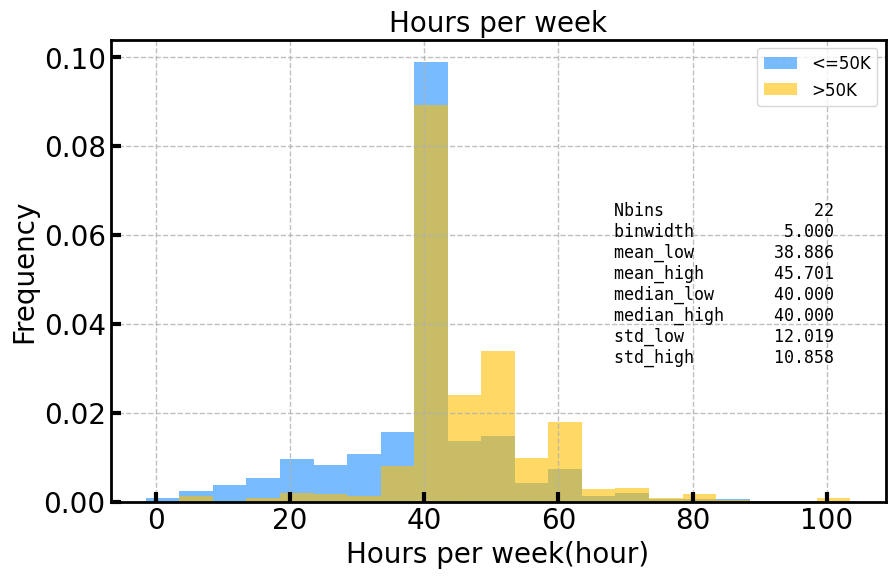

In [15]:
def plotDichotomisation(data):
    low, high = dichotomise(data)

    bins_age, _, _, _ = getHistoParamWithBinWidth(data['age'], 1)
    fig_age, ax_age = plt.subplots(figsize=(10, 6))
    ax_age.hist(low['age'], bins=bins_age, alpha=0.6, label='<=50K', density=True)
    ax_age.hist(high['age'], bins=bins_age, alpha=0.6, label='$>$50K', density=True)
    ax_age.set_xlabel('Age')
    ax_age.set_ylabel('Frequency')
    ax_age.set_title('Age')
    ax_age.legend()
    d_age = {'Nbins': len(bins_age), 
             'binwidth': bins_age[1] - bins_age[0],
             'mean_low': low['age'].mean(),
            'mean_high': high['age'].mean(),
            'median_low': low['age'].median(),
            'median_high': high['age'].median(),
            'std_low': low['age'].std(),
            'std_high': high['age'].std()
    }
    add_text_to_ax(0.65, 0.65, nice_string_output(d_age), ax_age, fontsize=12)

    bin_edu, _, _, _ = getHistoParamWithBinWidth(data['education'], 1)
    fig_edu, ax_edu = plt.subplots(figsize=(10, 6))
    ax_edu.hist(low['education'], bins=bin_edu, alpha=0.6, label='<=50K', density=True)
    ax_edu.hist(high['education'], bins=bin_edu, alpha=0.6, label='>50K', density=True)
    ax_edu.set_xlabel('Education')
    ax_edu.set_ylabel('Frequency')
    ax_edu.set_title('Education')
    ax_edu.legend()
    d_edu = {'Nbins': len(bin_edu),
             'binwidth': bin_edu[1] - bin_edu[0],
                'mean_low': low['education'].mean(),
                'mean_high': high['education'].mean(),
                'median_low': low['education'].median(),
                'median_high': high['education'].median(),
                'std_low': low['education'].std(),
                'std_high': high['education'].std()
    }
    add_text_to_ax(0.05, 0.65, nice_string_output(d_edu), ax_edu, fontsize=12)

    fig_gen, ax_gen = plt.subplots(figsize=(10, 6))
    width = 0.4 
    low_0 = low[low['gender'] == 0]
    low_1 = low[low['gender'] == 1]
    high_0 = high[high['gender'] == 0]
    high_1 = high[high['gender'] == 1]
    ax_gen.bar(np.arange(2) - width/2, [len(low_0), len(low_1)], width=width, alpha=0.6, label='<=50K')
    ax_gen.bar(np.arange(2) + width/2, [len(high_0), len(high_1)], width=width, alpha=0.6, label='>50K')

    ax_gen.set_xlabel('Gender')
    ax_gen.set_ylabel('Frequency')
    ax_gen.set_title('Gender')
    ax_gen.set_xticks([0, 1])
    ax_gen.legend()

    bins_hpw, _, _, _ = getHistoParamWithBinWidth(data['hpw'], 5)
    fig_hpw, ax_hpw = plt.subplots(figsize=(10, 6))
    ax_hpw.hist(low['hpw'], bins=bins_hpw, alpha=0.6, label='<=50K', density=True)
    ax_hpw.hist(high['hpw'], bins=bins_hpw, alpha=0.6, label='>50K', density=True)
    ax_hpw.set_xlabel('Hours per week(hour)')
    ax_hpw.set_ylabel('Frequency')
    ax_hpw.set_title('Hours per week')
    ax_hpw.legend()
    d_hpw = {'Nbins': len(bins_hpw),
             'binwidth': bins_hpw[1] - bins_hpw[0],
                'mean_low': low['hpw'].mean(),
                'mean_high': high['hpw'].mean(),
                'median_low': low['hpw'].median(),
                'median_high': high['hpw'].median(),
                'std_low': low['hpw'].std(),
                'std_high': high['hpw'].std()
    }
    add_text_to_ax(0.65, 0.65, nice_string_output(d_hpw), ax_hpw, fontsize=12)


plotDichotomisation(data_training)

true : isHigh50 = True

* `positive` : earning `more than 50k`
* negative : earning less than 50k

* true positive : correct prediction(>50k)
* true negative : correct prediction (<50k)
* false positive : incorrect prediction(>50k)
* false negative : incorrect precidtion(<50k)

* $\frac{FP}{False}$ = $\frac{FP}{FP + TN}$
* $\frac{TP}{Positive}$ = $\frac{TP}{TP + FP}$ :  precision   


* confusion matrix  
  
| Actual \ Predicted | Negative | Positive |
|--------------------|----------|----------|
| **Negative**       | TN       | FP       |
| **Positive**       | FN       | TP       |


In [16]:
def findOptimalCut(y_test, p, name, precisionMin=0.85):
    best = 0
    step = 0.01
    optimalCut = 0.75
    if name == 'AdaBoostClassifier':
        optimalCut = 0.5055
        # 0.5055
    elif name == 'LogisticRegression':
        optimalCut = 0.826
        # 0.826 : 81.48%
        
    for threshold in np.arange(0, 1 + step, step):
        p_high = (p > threshold)
        precision = precision_score(y_test, p_high, zero_division=0)
        if precision > best and precision >= precisionMin:
            best = precision
            optimalCut = threshold
    return optimalCut, best


In [17]:
def getBinsFromData(data):
    min = data.min()
    max = data.max()
    Nbins = int(np.sqrt(data.shape[0]*10))
    return np.linspace(min, max, Nbins)

In [85]:
def plotDecisionScore(p_high, p_low, name, precision, threshold, error, ranked_features, cm):
    fig, ax = plt.subplots(figsize=(12, 8))
    bins = getBinsFromData(p_high)
    ax.hist(p_low, bins=bins, alpha=0.6, label='income<=50K', histtype='step', hatch='\\\\', color = 'r', linestyle = '-')
    ax.hist(p_high, bins=bins, alpha=0.6, label='income>50K', histtype='step', hatch='//', color = 'k', linestyle = '-')
    ax.axvline(x=threshold, color=COLOUR[0], linestyle='--', label=f'threshold: {threshold:.3f}')
    ax.set_xlabel('Decision score')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Decision score distribition of {name}')
    ax.legend(loc = 'upper right')
    TN = cm[0]
    FP = cm[1]
    FN = cm[2]
    TP = cm[3]
    d = {
         'N_test' : len(p_high) + len(p_low),
         'N_high' : len(p_high), 
         'N_low' : len(p_low),
         'threshold' : f'{threshold:.3f}',
         'precision' : f'{precision:.2%}',
         'error' : f'{error:.2%}',
         'N_bins' : len(bins),
         'bin width' : bins[1] - bins[0],
        }
    d_cm = {'TN': TN, 'FP': FP, 'FN': FN, 'TP': TP}
    d_rank = {'ranking':  'importance'}
    for i, (feature, importance) in enumerate(ranked_features):
        d_rank[f'{i+1:d}. {feature}'] = f'{importance:.3f}'
    
    add_text_to_ax(0.14, 0.95, nice_string_output(d), ax, fontsize=12)
    add_text_to_ax(0.85, 0.66, nice_string_output(d_cm), ax, fontsize=12)
    add_text_to_ax(0.40, 0.95, nice_string_output(d_rank), ax, fontsize=12)
    

In [19]:
def getPredictionError(TN, FP, FN, TP):
    total = TN + FP + FN + TP
    return (FP + FN) / total

In [20]:
def sortByImportance(classifier, X_train, y_train, X_test, y_test):
    # tree-based models
    if hasattr(classifier, 'feature_importances_'):
        importances = classifier.feature_importances_
        indices = np.argsort(importances)[::-1]
        ranked_features = [(X_train.columns[i], importances[i]) for i in indices]
        
    # linear models
    elif hasattr(classifier, 'coef_'):
        try:
            importances = np.abs(classifier.coef_[0])
            indices = np.argsort(importances)[::-1]
            ranked_features = [(X_train.columns[i], importances[i]) for i in indices]
        except TypeError:
            importances = np.abs(classifier.coef_).mean(axis=0)
            indices = np.argsort(importances)[::-1]
            ranked_features = [(X_train.columns[i], importances[i]) for i in indices]

    # permutation importance
    else:
        result = permutation_importance(classifier, X_test, y_test, n_repeats=10, random_state=42)
        indices = result.importances_mean.argsort()[::-1]
        ranked_features = [(X_train.columns[i], result.importances_mean[i]) for i in indices]
    
    return ranked_features


In [21]:
def displayConfusionMatrix(TN, FP, FN, TP):
    print(f'Confusion matrix:')
    print('& Negative & Positive \\\\ \hline')
    print('False &', FN, '&', FP, '\\\\')
    print('True &', TN, '&', TP, '\\\\')
    print()    

In [51]:
def displayStats(test_low, test_high, train_low, train_high):
    # Define a helper function to format the rows
    def format_row(label, data_high, data_low):
        return (f"{label} & "
                f"{data_high.mean():.2f} & {data_high.median():.0f} & {data_high.std():.2f} & "
                f"{data_low.mean():.2f} & {data_low.median():.0f} & {data_low.std():.2f} \\\\")
    
    # Print the table rows for Age
    print("\\textbf{Age} & & & & & & \\\\")
    print(format_row("$>$ 50k", test_high['age'], train_high['age']))
    print(format_row("$\\le$ 50k", test_low['age'], train_low['age']))
    print("\\midrule")
    
    # Print the table rows for Education
    print("\\textbf{Education} & & & & & & \\\\")
    print(format_row("$>$ 50k", test_high['education'], train_high['education']))
    print(format_row("$\\le$ 50k", test_low['education'], train_low['education']))
    print("\\midrule")
    
    # Print the table rows for Hours per Week
    print("\\textbf{Hours per Week} & & & & & & \\\\")
    print(format_row("$>$ 50k", test_high['hpw'], train_high['hpw']))
    print(format_row("$\\le$ 50k", test_low['hpw'], train_low['hpw']))
    print()


In [71]:
def classifyCore(data, classifier):
    ranState = 75
    testSize = 0.45
    name = classifier.__class__.__name__
    # features: independent variables
    features = data.drop('isHigh50', axis=1)
    # target: dependent variable
    target = data['isHigh50']
    
    feature_train, feature_test, target_train, target_test = train_test_split(features, target, test_size=testSize, random_state=ranState)
    classifier.fit(feature_train, target_train)
    p = classifier.predict_proba(feature_test)[:, 1]

    label_high_test = feature_test[target_test == True]
    label_low_test = feature_test[target_test == False]

    label_high_train = feature_train[target_train == True]
    label_low_train = feature_train[target_train == False]
    
    p_high = classifier.predict_proba(label_high_test)[:, 1]
    p_low = classifier.predict_proba(label_low_test)[:, 1]

    # threshold 
    threshold, bestScore = findOptimalCut(target_test, p, name, precisionMin=0.85)
    predicted_high = (p > threshold)
    predicted_low = (p <= threshold)
    TN, FP, FN, TP = confusion_matrix(target_test, predicted_high).ravel()

    # print stats
    # displayStats(label_low_test, label_high_test, label_low_train, label_high_train)

    # print confusion matrix
    # displayConfusionMatrix(TN, FP, FN, TP)
    
    # precision
    precision = TP / (TP + FP)
    # error
    error = getPredictionError(TN, FP, FN, TP)

    cm = [TN, FP, FN, TP]

    ranked_features = sortByImportance(classifier, feature_train, target_train, feature_test, target_test)
    plotDecisionScore(p_high, p_low, name, precision, threshold, error, ranked_features, cm)
    
    return classifier, threshold


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


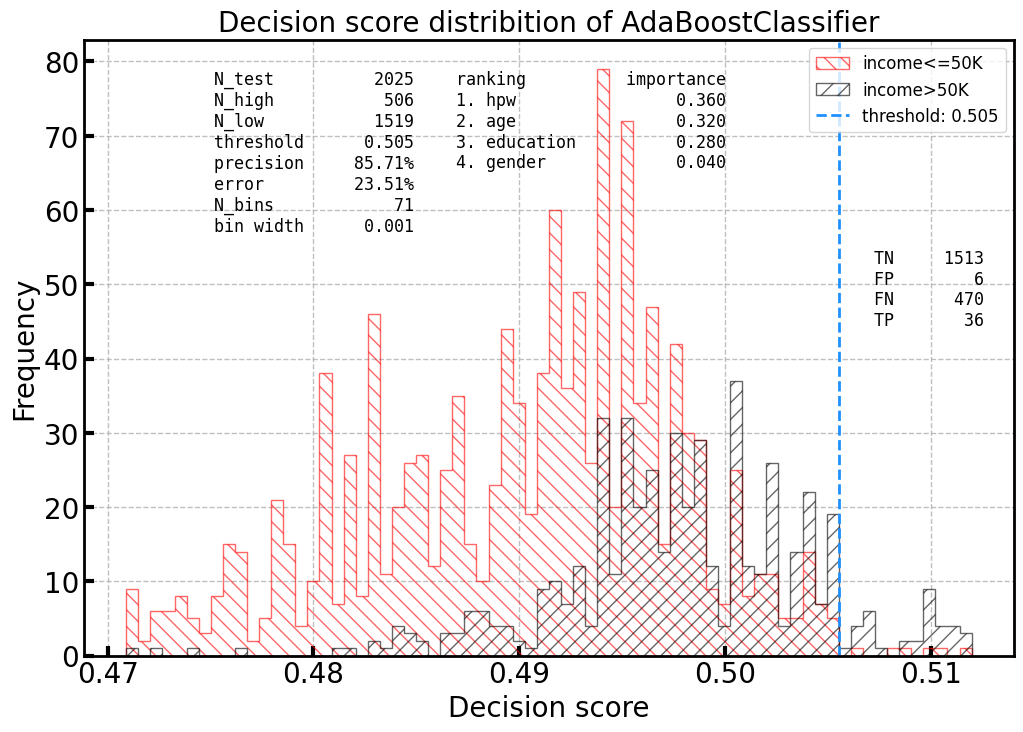

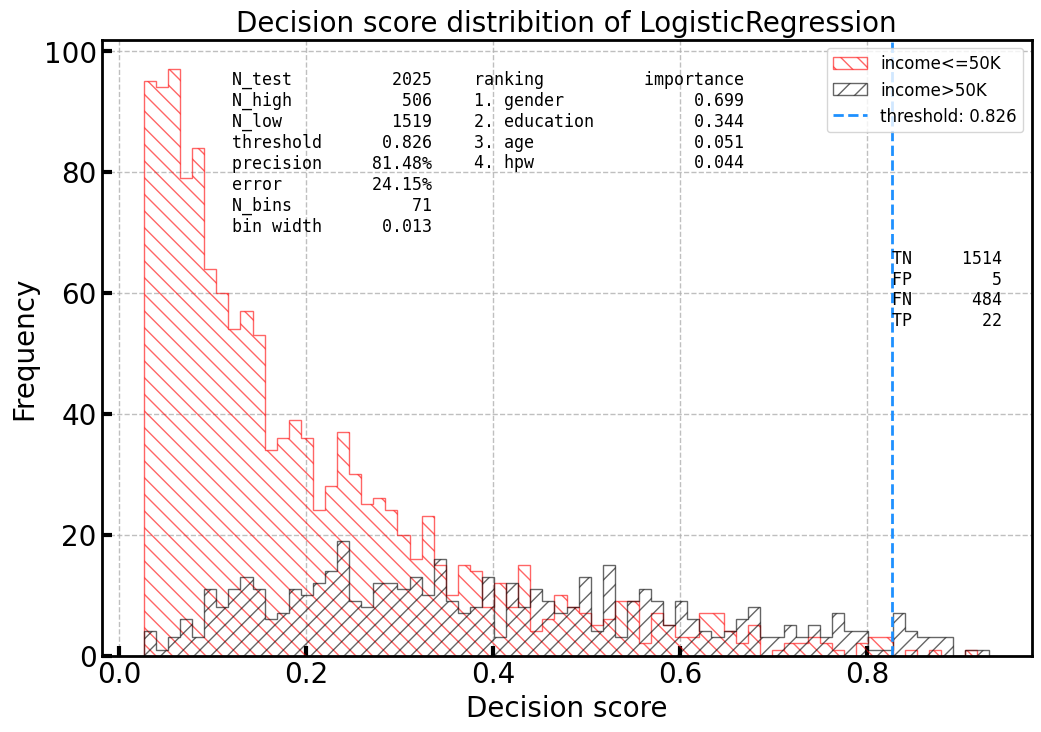

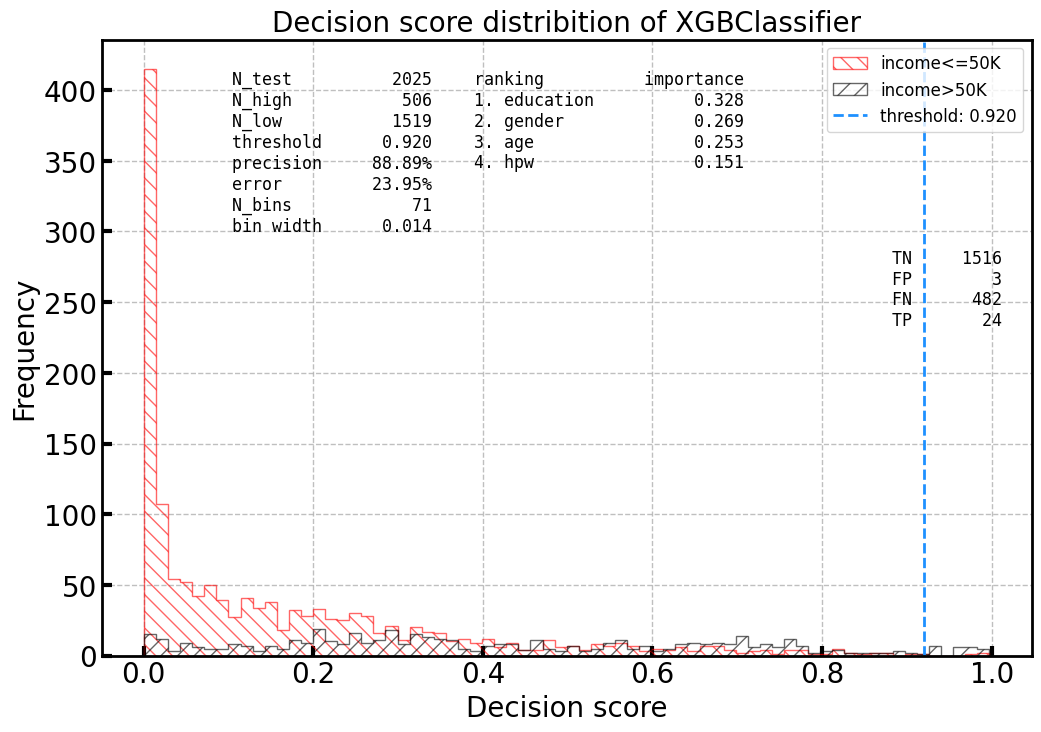

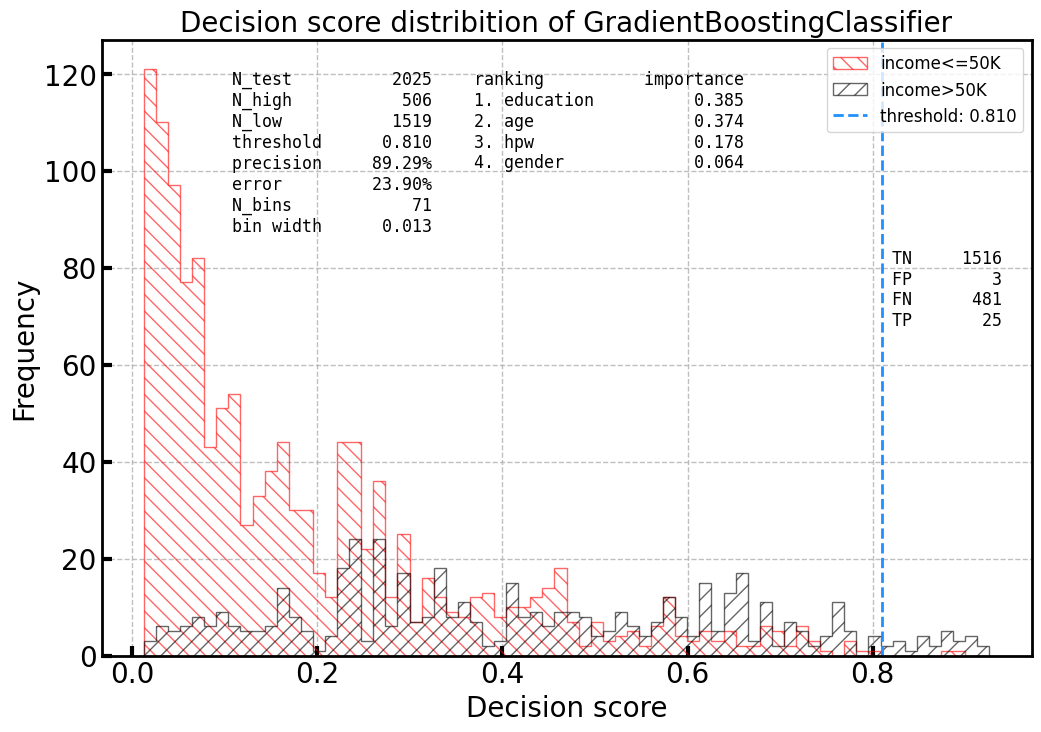

In [86]:
def classifyInterface(data):
    classifiers = [
    AdaBoostClassifier(),
    LogisticRegression(),
    xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    GradientBoostingClassifier(),
    ]
    
    processed_classifiers = []
    processed_thresholds = []

    
    for classifier in classifiers:
        c, t = classifyCore(data, classifier)
        processed_classifiers.append(c)
        processed_thresholds.append(t)
    return processed_classifiers, processed_thresholds

classifiers, thresholds = classifyInterface(data_training)

In [ ]:
def predictRealCore(classifier, threshold, data_real):
    features = data_real  # Use the data directly, as there's no 'ID' column to drop
    p = classifier.predict_proba(features)[:, 1]
    predict_high = p > threshold
    predict_low = p <= threshold

    # Instead of collecting IDs, collect indices
    indices_high = features.index[predict_high]
    indices_low = features.index[predict_low]

    return indices_high, indices_low, p


In [ ]:
def predictRealInterface(data_real, classifiers, thresholds):
    predictions = {}
    
    for classifier, threshold in zip(classifiers, thresholds):
        name = classifier.__class__.__name__
        high_i, low_i, probabilities = predictRealCore(classifier, threshold, data_real)
        
        predictions[name] = {
            "high_i": high_i.values,  # Extract numpy array of IDs
            "low_i": low_i.values,  # Extract numpy array of IDs
            "p": probabilities
        }
    
    return predictions
predition_real = predictRealInterface(data_real, classifiers, thresholds)

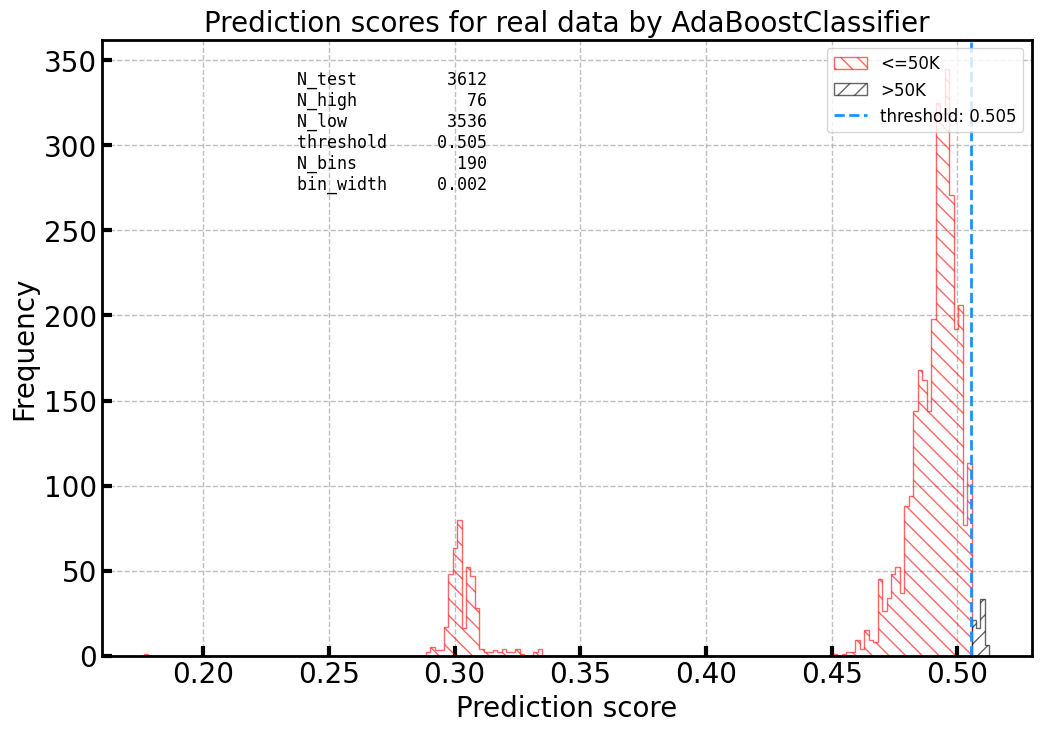

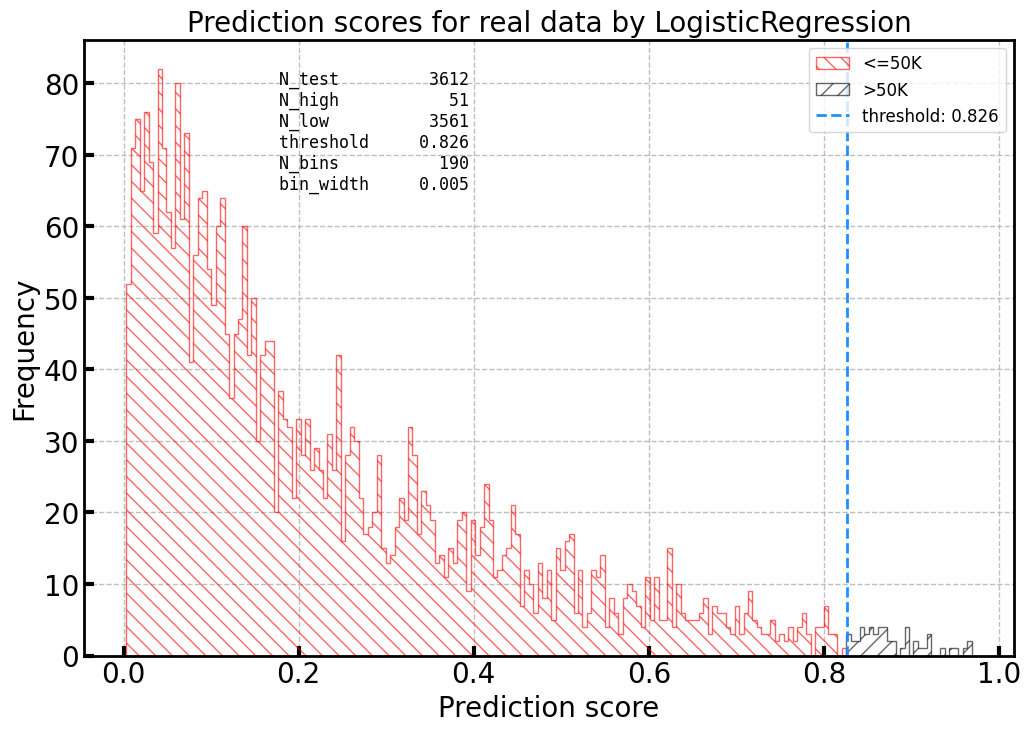

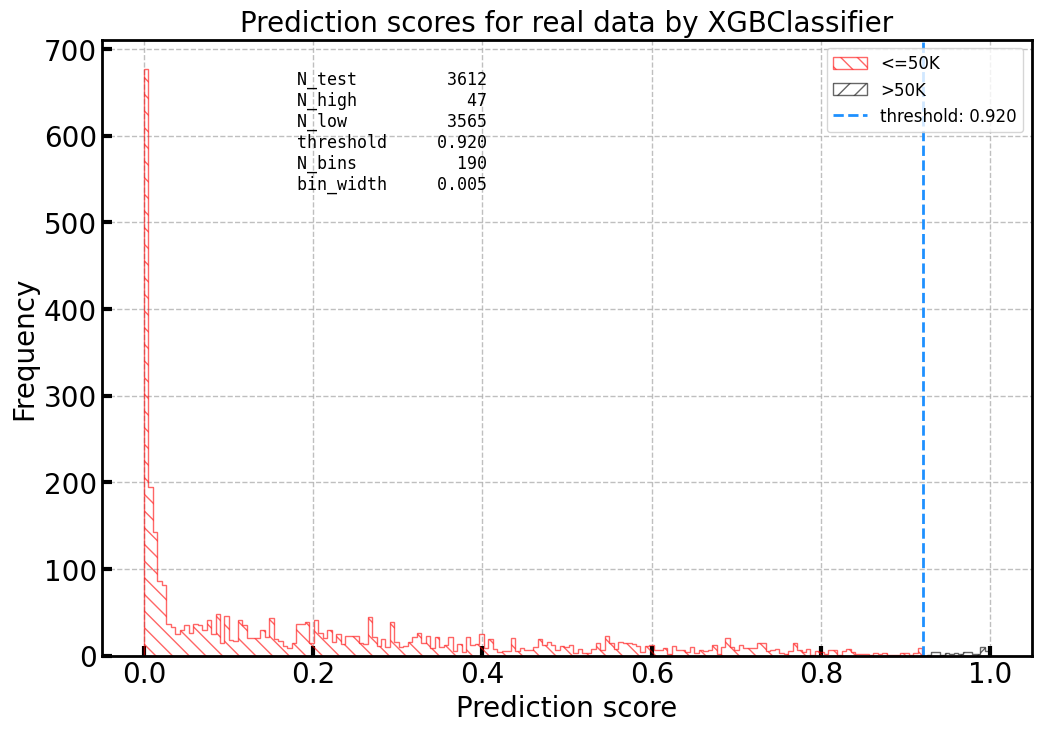

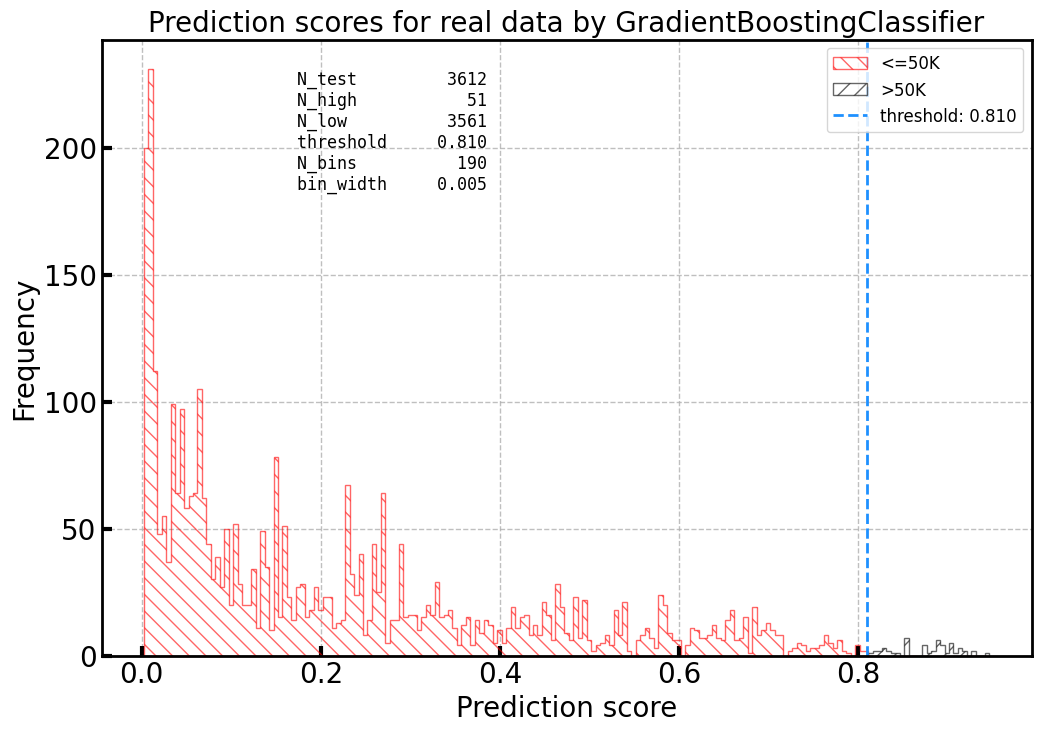

In [ ]:
def plotRealPrediction(data_real, predictions, classifiers, thresholds):
    name_to_threshold = {classifier.__class__.__name__: threshold for classifier, threshold in zip(classifiers, thresholds)}
    # predictions = predictRealInterface(data_real, classifiers, thresholds)
    
    # Loop through each classifier's predictions
    for name, prediction in predictions.items():
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Calculate bins
        bins = getBinsFromData(prediction['p'])
        
        # Plot histograms
        ax.hist(prediction['p'][prediction['low_i']], bins=bins, alpha=0.6, label='<=50K', histtype='step', hatch='\\\\', color='r', linestyle='-')
        ax.hist(prediction['p'][prediction['high_i']], bins=bins, alpha=0.6, label='>50K', histtype='step', hatch='//', color='k', linestyle='-')
        ax.axvline(x=name_to_threshold.get(name, 0), color=COLOUR[0], linestyle='--', label=f'threshold: {name_to_threshold.get(name, 0):.3f}')
        
        ax.set_xlabel('Prediction score')
        ax.set_ylabel('Frequency')
        ax.set_title(f'Prediction scores for real data by {name}')
        ax.legend(loc='upper right')
        
        # Use the name-to-threshold mapping
        threshold = name_to_threshold.get(name, 0)  # Default to 0 if not found, adjust as necessary
        
        d = {
            'N_test': len(prediction['p']),
            'N_high': len(prediction['high_i']), 
            'N_low': len(prediction['low_i']),
            'threshold': f"{threshold:.3f}",
            'N_bins': len(bins),
            'bin_width': bins[1] - bins[0]
        }
        add_text_to_ax(0.21, 0.95, nice_string_output(d), ax, fontsize=12)
plotRealPrediction(data_real, predition_real, classifiers, thresholds)

In [ ]:
def writeIDtoTxt(data, fileName):
    path = ''
    data.to_csv(path+fileName, index=False, header=False)

In [ ]:
def writePredictionsToFile(predictions):
    for classifier, result in predictions.items():
        if classifier == 'AdaBoostClassifier':
            fileName_high = 'Cyan_Jo.high_ID.txt'
            fileName_low = 'Cyan_Jo.low_ID.txt'
        else:
            subDir = 'results/'
            if not os.path.exists(subDir):
                os.makedirs(subDir)
            fileName_high = subDir+'Cyan_Jo.high_ID_' + classifier + '.txt'
            fileName_low = subDir+'Cyan_Jo.low_ID_' + classifier + '.txt'
        
        high_i = result["high_i"]
        low_i = result["low_i"]
        
        writeIDtoTxt(pd.DataFrame(high_i), fileName_high)
        writeIDtoTxt(pd.DataFrame(low_i), fileName_low)
writePredictionsToFile(predition_real)